# 이미지에서 랜드마크 추출

In [5]:
import cv2
import pickle
import numpy as np
import json
import os
from glob import glob
import torch
from PIL import Image
from torch import nn
from torchvision import transforms
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import optim
from tqdm.auto import tqdm
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sys import getsizeof
from pympler import asizeof
import pandas as pd
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [6]:
PATH = 'C:/PlayData/sign_English'

folder_list = os.listdir(PATH)

In [7]:
folder_list

['d', 'e', 'h', 'l', 'o', 'r', 'w']

In [8]:
img_list = []
img_tuple_list = []
folder_name = [0,1,2,3]
count=0
transform = transforms.Compose([
    transforms.Resize((128,128))
])
for folder in tqdm(folder_list):
    folder_path = glob(f'C:/PlayData/sign_English/{folder}/*.jpg')
    
    for i in range(len(folder_path)):
        folder_path[i] = folder_path[i].replace('\\', '/')
        image = Image.open(folder_path[i])
        image = transform(image)
        # 이미지를 흑백으로 변환
        image = image.convert('L')
        # 이미지 데이터 디코딩
        image_data = np.array(image)   
        # 이미지 데이터 정규화
        image_data = image_data.astype("float32") / 255.0 
        # NumPy 배열을 PyTorch 텐서로 변환
        image_tensor = transforms.ToTensor()(image_data)
        img_tuple_list.append((image_tensor,count))
    count +=1



  0%|          | 0/7 [00:00<?, ?it/s]

torch.Size([1, 128, 128])


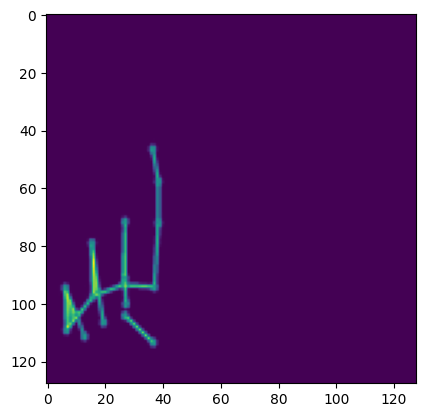

In [13]:
a = img_tuple_list[1][0]
print(a.shape)
import numpy as np
a = np.squeeze(a)  # remove the first dimension with length 1
plt.imshow(a)


In [14]:
X, y = zip(*img_tuple_list)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
train_data = [(x, y) for x, y in zip(X_train, y_train)]
test_data = [(x, y) for x, y in zip(X_test, y_test)]

In [15]:
# hyper parameter
BATCH_SIZE = 30
EPOCHS = 5
LEARNING_RATE = 1e-3


In [17]:
train_loader = DataLoader(train_data,batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data,batch_size=BATCH_SIZE)

In [18]:
# model 생성
# Convolution, Maxpooling, flatten
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(0.2)
    )    
    self.layer2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(0.2)

    )
    self.softmax = nn.Softmax()
    self.fc = nn.Linear(32*32*32,7)
  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = x.view(x.size(0),-1)
    x = self.fc(x)
    x = self.softmax(x)
    return x



In [19]:
model = CNN()
model.to(device)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
  )
  (softmax): Softmax(dim=None)
  (fc): Linear(in_features=32768, out_features=7, bias=True)
)

In [20]:
getsizeof(train_data)

14672

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

4번째 train_loss : 1.54 test_loss : 1.6 Accuracy : 98.07%


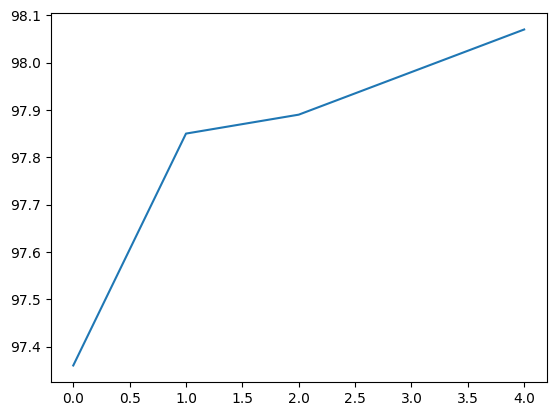

torch.Size([193])


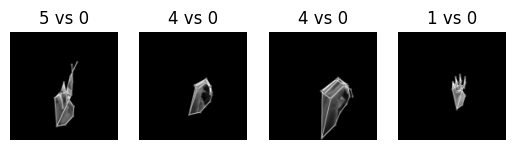

In [22]:
total_acc = []
for epoch in range(EPOCHS):
  # 학습
  train_loss=[]
  for img, label in tqdm(train_loader):
    img = img.to(device)
    label = label.to(device)
    
    optimizer.zero_grad()
    pred = model(img)
    loss = criterion(pred, label)
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  # 평가
  test_loss=[]
  test_sources = []
  with torch.no_grad():
    for img, label in test_loader:
      pred = model(img)
      loss = criterion(pred, label)
      # pred = model(img)
      # loss = criterion(pred, label)
      test_loss.append(loss.item())
      test_sources.append((img[pred.cpu().argmax(axis=1)!=label.cpu()],
                           label[pred.cpu().argmax(axis=1)!=label.cpu()],pred.cpu().argmax(axis=1)[pred.cpu().argmax(axis=1)!=label.cpu()])) # label과 pred 값이 다른 부분만 test_sources에 담기
  # 노트북 파일 기존 프린트 되었던 화면을 지우는 코드
  clear_output()

  # 인식 잘 안된 부분의 시각화를 위해서 img, label, pred를 모아서 정리
  imgs = [x[0] for x in test_sources]
  imgs = torch.cat(imgs, axis=0)
  labels = [x[1] for x in test_sources]
  labels = torch.cat(labels, axis=0)
  preds = [x[2] for x in test_sources]
  preds = torch.cat(preds, axis=0)

  # 정확도 계산을 위한 코드. 다양하게 다른 방법도 가능함
  # sklearn의 metric 이용하는 방법 추천
  wrongs = [len(x[0]) for x in test_sources]
  acc = round(100-(sum(wrongs)/100),2)

  # 정확도 추이를 보기 위하여 각 에폭에서의 정확도 정보 수집
  total_acc.append(acc)

  # 학습 진행 상황 출력
  print("{}번째 train_loss : {} test_loss : {} Accuracy : {}%".format(epoch, round(np.array(train_loss).mean(),2),round(np.array(test_loss).mean(),2),
                                                                   acc))
  if img.shape[0]<1:continue # 혹시 더이상 오분류 내용이 없으면 지나가도록 세팅

  # 정확도 그래프 그리기
  plt.plot(total_acc)
  plt.show()

  # 오분류 내용이 어떤건지 알기 위해 오분류 내용 4개 뽑아서 label과 pred 글자 넣어서 표시
  for i in range(4):
    plt.subplot(1,4,i+1)    
    plt.imshow(np.squeeze(imgs[i][0]), cmap='gray')    
    plt.title("{} vs {}".format(labels[i].item(),preds[i].item()))
    plt.axis('off')
  print(labels.shape)
  plt.show()

In [19]:
model

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
  )
  (softmax): Softmax(dim=None)
  (fc): Linear(in_features=32768, out_features=7, bias=True)
)

In [23]:
# 모델 피클로 저장
pickle_file_path = "sign_ver1-pkl.pkl"
with open(pickle_file_path, "wb") as f:
    pickle.dump(model, f)

In [24]:
# 저장된 피클 파일을 불러옴
with open(pickle_file_path, "rb") as f:
    model = pickle.load(f)

model.eval()

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
  )
  (softmax): Softmax(dim=None)
  (fc): Linear(in_features=32768, out_features=7, bias=True)
)

In [33]:
pred.argmax().item()

37

In [25]:
# 손 랜드마크 저장하는 코드
import cv2
import mediapipe as mp
import numpy as np
num = 0 # 시작하기전에 사진 번호 맞춰주기
cap = cv2.VideoCapture(0)
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
landmark_lists = []
text_list = []
text_list_2=[]
with mp_hands.Hands(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands:
    while cap.isOpened():
        ret, frame = cap.read()
        success, image = cap.read()
        frame = cv2.flip(frame, 1)
        
        if not success:
            print("Ignoring empty camera frame.")
            continue

        image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
        image.flags.writeable = True
        results = hands.process(image)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

                # 손의 랜드마크만 추출
                global landmark_list
                landmark_list = []
                for landmark in hand_landmarks.landmark:
                    landmark_x = min(int(landmark.x * image.shape[1]), image.shape[1]-1)
                    landmark_y = min(int(landmark.y * image.shape[0]), image.shape[0]-1)
                    landmark_list.append([landmark_x, landmark_y])
                landmark_array = np.array(landmark_list)
                
                # 손의 랜드마크만 저장
                hand_image = np.zeros_like(image)
                mp_drawing.draw_landmarks(
                    hand_image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                hand_landmarks_image = cv2.cvtColor(hand_image, cv2.COLOR_RGB2GRAY)  # 컬러 이미지 대신 그레이스케일 이미지로 변경
                hand_landmarks_image = cv2.threshold(hand_landmarks_image, 1, 255, cv2.THRESH_BINARY)[1]
                hand_landmarks_image = cv2.merge([hand_landmarks_image, hand_landmarks_image, hand_landmarks_image])
                hand_landmarks_image = cv2.bitwise_and(image, hand_landmarks_image)

                # cv2.imshow('Hand Landmarks', hand_landmarks_image)
                hand_landmarks_image = cv2.cvtColor(hand_landmarks_image, cv2.COLOR_BGR2GRAY)
                hand_landmarks_image = cv2.resize(hand_landmarks_image, (128, 128))
                hand_landmarks_image = np.expand_dims(hand_landmarks_image, axis=0) # 1x128x128로 만들어주기
                hand_landmarks_image = torch.Tensor(hand_landmarks_image)
                pred = model(hand_landmarks_image.unsqueeze(0))
                
        # text = str(pred.argmax().item())  # 예측 결과를 문자열로 변환
        font = cv2.FONT_HERSHEY_SIMPLEX
        img_pil = Image.fromarray(image)
        image = np.array(img_pil)
        org = (100, 100)  # 문자열을 쓰고자 하는 위치
        fontScale = 2
        color = (0, 0, 255) 
        thickness = 3
        a=str(folder_list[pred.argmax().item()])
        if pred.argmax().item() is not None:
            text = a      
            text_list.append(text)
        else:
            text = "No prediction"
            print("Err")
        text_list_1 = ', '.join(text_list_2)
        if all(x == text_list[0] for x in text_list):
            if len(text_list) >15:
                text_list_2.append(text_list[0])
                text_list=[]
                
        # 이미지에 문자열 표시
        cv2.putText(image, text, org, font, fontScale, color, thickness)
        cv2.putText(image, text_list_1, (100,200), font, fontScale, color, thickness)
        cv2.imshow('MediaPipe Hands', image)
        
        
        
        key = cv2.waitKey(1)
        if key == ord('s'):
            num += 1
            landmark_lists.append(landmark_list)
            if len(landmark_lists) == 300:
                a= pd.DataFrame(landmark_lists)
                a.to_csv('landmarks_b',index=False)
                cv2.destroyAllWindows()
        if key == ord('q'):
            cv2.destroyAllWindows()
            break
            

cap.release()
# 

C:\Users\2580j\AppData\Local\Temp\ipykernel_24788\4019014158.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)
